In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("annotated.csv")
df

,pocket,protein,ligand,rank,rmsd,obrmsd,flexobrmsd,fmaxrmsd,score,group,annotation
0,ABL1,1FPU,3QRK,0,1.12474,1.12474,0.75627,1.09286,-11.82862,1,1
1,ABL1,1FPU,3QRK,10,7.46179,7.46179,1.38199,2.77094,-11.55337,1,0
2,ABL1,1FPU,3QRK,11,8.08863,8.08863,1.44861,2.51482,-11.47044,1,0
3,ABL1,1FPU,3QRK,12,8.47072,8.47072,1.60736,2.34249,-11.35890,1,0
4,ABL1,1FPU,3QRK,13,8.45633,8.45633,1.61014,2.35856,-11.32845,1,0
...,...,...,...,...,...,...,...,...,...,...,...
165586,XIAP,5C84,4KMP,5,9.60539,9.60539,1.43189,2.28256,-7.57331,63,0
165587,XIAP,5C84,4KMP,6,8.41238,8.41238,1.30168,2.39061,-7.51172,63,0
165588,XIAP,5C84,4KMP,7,6.88340,6.88340,0.95547,1.40152,-7.40088,63,0
165589,XIAP,5C84,4KMP,8,5.19961,5.19961,2.08915,2.97329,-7.32203,63,0


In [3]:
def load_scores(df, model, prefix):
    score = pd.concat((
    pd.read_csv(f"../training/{model}/{prefix}test0.out", sep=" ", header=None),
    pd.read_csv(f"../training/{model}/{prefix}test1.out", sep=" ", header=None),
    pd.read_csv(f"../training/{model}/{prefix}test2.out", sep=" ", header=None),
    ))

    if prefix == "nc":
        # No affinity column
        to_drop = [1,2,4,5,6,7]
    elif prefix == "cluster":
        to_drop = [1,2,3,5,6,7,8]


    score.drop(columns=to_drop, inplace=True)
    score.rename(columns={0: "CNNscore", 3: "name", 4: "name"}, inplace=True)
    score.dropna(inplace=True) # Last row contains NaN (it is  actually a comment)

    def getid(row):
        namesplit = row["name"].split("/")

        pocket = namesplit[1]

        split = namesplit[-1].split("_")

        protein = split[0]
        ligand = split[2]

        rank = int(split[-1][1:].replace(".gninatypes", ""))

        return (pocket, protein, ligand, rank)

    score[["pocket", "protein", "ligand", "rank"]] = score.apply(getid, axis=1, result_type="expand")
    score.drop(columns="name", inplace=True)

    df_score = df.merge(score, on=["pocket", "protein", "ligand", "rank"])

    return df_score

In [4]:
#df_score = load_scores(df, model, prefix)
#df_score

In [5]:
def topN(df, nmax):

    n_pockets = 0
    
    # Store top N metrics
    top_smina = [0] * nmax
    top_gnina = [0] * nmax
    top_best = [0] * nmax

    # Loop over pockets
    for _, group in df.groupby(by=["pocket"]):
        n_smina = [0] * nmax
        n_gnina = [0] * nmax
        n_best = [0] * nmax

        # Compute percentage of targets with good pose in top N
        n_targets = 0
        for _, tgroup in group.groupby("protein"):
            smina = tgroup.sort_values(by="score", ascending=True)
            gnina = tgroup.sort_values(by="CNNscore", ascending=False)
            best = tgroup.sort_values(by="rmsd", ascending=True)

            for n in range(1, nmax + 1):
                # At least one good pose amongst the top N
                if (smina["annotation"].iloc[:n] == 1).any():
                    n_smina[n-1] += 1

                if (gnina["annotation"].iloc[:n] == 1).any():
                    n_gnina[n-1] += 1
                
                if (best["annotation"].iloc[:n] == 1).any():
                    n_best[n-1] += 1

            n_targets += 1

        # Accumulate results for all targets
        for n in range(1, nmax + 1):
            top_smina[n-1] += n_smina[n-1] / n_targets * 100
            top_gnina[n-1] += n_gnina[n-1]  / n_targets * 100
            top_best[n-1] += n_best[n-1]  / n_targets * 100

        n_pockets += 1

    # One pocket has been removed from the training set
    # for lack of actives
    assert n_pockets == 91

    # Return TopN of targets, averaged per pocket
    top_smina_avg = np.array(top_smina) / n_pockets
    top_gnina_avg = np.array(top_gnina) / n_pockets
    top_best_avg =  np.array(top_best) / n_pockets
    return np.array([list(range(1,nmax+1)), top_smina_avg, top_gnina_avg, top_best_avg]).T

In [6]:
nmax = 10

In [7]:
for model in ["default2017", "default2018", "dense"]:
    prefix = "nc"
    modelname = f"{model}-noaffinity-nostratified"

    df_score = load_scores(df, modelname, prefix)

    for crystal in ["", "nocrystal_"]:
        if crystal == "":
            t  = topN(df_score, nmax)
        elif crystal == "nocrystal_":
            # Remove crystal
            t = topN(df_score[df_score["rank"] != 0], nmax)
        else:
            raise Exception

        df_top = pd.DataFrame(t, columns=["N", "smina", "gnina", "best"])
        df_top.to_csv(f"TopN/{crystal}{modelname}.csv", index=None)

In [8]:
for model in ["default2017", "default2018", "dense"]:
    prefix = "cluster"
    modelname = f"{model}-noaffinity"

    df_score = load_scores(df, modelname, prefix)

    for crystal in ["", "nocrystal_"]:
        if crystal == "":
            t  = topN(df_score, nmax)
        elif crystal == "nocrystal_":
            # Remove crystal
            t = topN(df_score[df_score["rank"] != 0], nmax)
        else:
            raise Exception

        df_top = pd.DataFrame(t, columns=["N", "smina", "gnina", "best"])
        df_top.to_csv(f"TopN/{crystal}{modelname}.csv", index=None)

In [9]:
crystal_nostratified = pd.concat(
    (
        pd.read_csv("TopN/default2017-noaffinity-nostratified.csv",index_col=0).rename(columns={"gnina": "default2017"}),
        pd.read_csv("TopN/default2018-noaffinity-nostratified.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
        pd.read_csv("TopN/dense-noaffinity-nostratified.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
    ),
    axis=1,
)
crystal_nostratified

,smina,default2017,best,default2018,dense
N,,,,,
1.0,31.730625,47.210730,92.928415,51.965118,48.931525
2.0,41.028493,63.332378,92.928415,65.361845,61.791130
3.0,47.046652,71.255309,92.928415,71.622192,68.690338
4.0,50.156765,76.028671,92.928415,74.740131,73.794221
5.0,54.230891,79.354607,92.928415,77.206549,76.899660
6.0,57.103549,81.841360,92.928415,78.952117,79.561153
7.0,59.010673,83.498714,92.928415,80.603113,81.612156
8.0,62.412560,85.173886,92.928415,82.204561,82.886893
9.0,64.008278,86.239321,92.928415,82.959003,84.210188


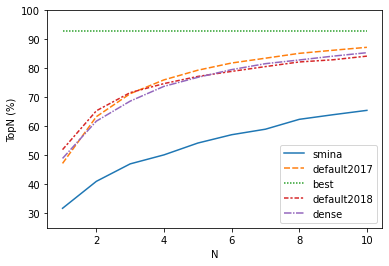

In [17]:
sns.lineplot(data=crystal_nostratified)
plt.ylabel("TopN (%)")
plt.ylim([25,100])
plt.savefig("plots/TopN-crystal-nostratified.pdf")
plt.savefig("plots/TopN-crystal-nostratified.png")

In [11]:
crystal_stratified = pd.concat(
    (
        pd.read_csv("TopN/default2017-noaffinity.csv",index_col=0).rename(columns={"gnina": "default2017"}),
        pd.read_csv("TopN/default2018-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
        pd.read_csv("TopN/dense-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
    ),
    axis=1,
)
crystal_stratified

,smina,default2017,best,default2018,dense
N,,,,,
1.0,31.730625,45.303727,92.928415,45.615792,43.914256
2.0,41.028493,58.130832,92.928415,61.118399,58.578401
3.0,47.046652,64.793380,92.928415,68.697321,67.215642
4.0,50.156765,69.345292,92.928415,73.301069,72.017799
5.0,54.230891,73.427535,92.928415,76.629929,74.461908
6.0,57.103549,75.806509,92.928415,78.750247,75.980730
7.0,59.010673,78.565483,92.928415,80.723425,78.039894
8.0,62.412560,80.391600,92.928415,81.814695,79.892262
9.0,64.008278,82.480134,92.928415,83.004981,81.219388


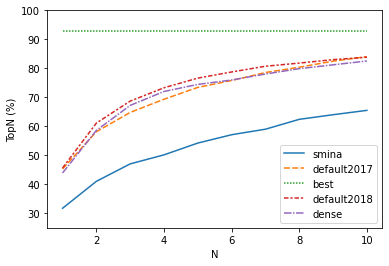

In [18]:
sns.lineplot(data=crystal_stratified)
plt.ylabel("TopN (%)")
plt.ylim([25,100])
plt.savefig("plots/TopN-crystal-stratified.pdf")
plt.savefig("plots/TopN-crystal-stratified.png")

In [13]:
nocrystal_nostratified = pd.concat(
    (
        pd.read_csv("TopN/nocrystal_default2017-noaffinity-nostratified.csv",index_col=0).rename(columns={"gnina": "default2017"}),
        pd.read_csv("TopN/nocrystal_default2018-noaffinity-nostratified.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
        pd.read_csv("TopN/nocrystal_dense-noaffinity-nostratified.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
    ),
    axis=1,
)
nocrystal_nostratified

,smina,default2017,best,default2018,dense
N,,,,,
1.0,28.201177,30.976120,74.790018,32.727551,30.034520
2.0,36.782877,41.419334,74.790018,46.023578,40.473210
3.0,42.380985,47.364647,74.790018,51.197717,47.109940
4.0,45.076304,52.404429,74.790018,55.085085,52.193470
5.0,48.092379,55.858494,74.790018,58.065849,55.512682
6.0,50.264707,57.715408,74.790018,60.006528,58.045870
7.0,51.823790,59.590596,74.790018,61.704176,60.157246
8.0,53.401534,61.352774,74.790018,62.657140,62.208109
9.0,54.553835,62.434354,74.790018,63.549408,63.509182


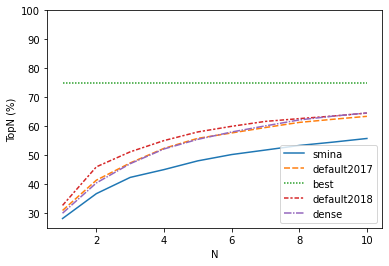

In [19]:
sns.lineplot(data=nocrystal_nostratified)
plt.ylabel("TopN (%)")
plt.ylim([25,100])
plt.savefig("plots/TopN-nocrystal-nostratified.pdf")
plt.savefig("plots/TopN-nocrystal-nostratified.png")

In [15]:
nocrystal_stratified = pd.concat(
    (
        pd.read_csv("TopN/nocrystal_default2017-noaffinity.csv",index_col=0).rename(columns={"gnina": "default2017"}),
        pd.read_csv("TopN/nocrystal_default2018-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
        pd.read_csv("TopN/nocrystal_dense-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
    ),
    axis=1,
)
nocrystal_stratified

,smina,default2017,best,default2018,dense
N,,,,,
1.0,28.201177,28.443529,74.790018,27.200595,26.641619
2.0,36.782877,38.088044,74.790018,38.916846,38.473830
3.0,42.380985,43.805419,74.790018,46.033080,45.756285
4.0,45.076304,47.545025,74.790018,50.439052,50.340724
5.0,48.092379,51.579560,74.790018,53.232399,53.369286
6.0,50.264707,53.489684,74.790018,56.010649,55.126754
7.0,51.823790,56.081188,74.790018,58.304491,56.919524
8.0,53.401534,57.573404,74.790018,59.736747,58.279029
9.0,54.553835,59.363599,74.790018,60.614902,59.538319


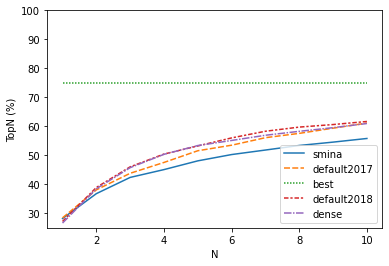

In [20]:
sns.lineplot(data=nocrystal_stratified)
plt.ylabel("TopN (%)")
plt.ylim([25,100])
plt.savefig("plots/TopN-nocrystal-stratified.pdf")
plt.savefig("plots/TopN-nocrystal-stratified.png")